# Movie Studio Startup - What movies should we make?

## Business Objective

To provide a detailed analysis on movies that have done well in the recent past and make recommendations to the client, Microsoft Studios, about the kind of movies and markets they should focus on to ensure maximum success and profitability.

Success of a movie can be defined in a myriad ways: awards, critical acclaim, ratings etc. to name a few. To keep things simple here, the analysis will be focused solely on revenue generated by a movie. The initial goal is to gain a foothold in the industry and establish a baseline before experimenting and taking on riskier ventures.

## Datatset

For movie information, we will be using database file from [IMDB](https://www.imdb.com/): im.db. Following image shows the database structure:

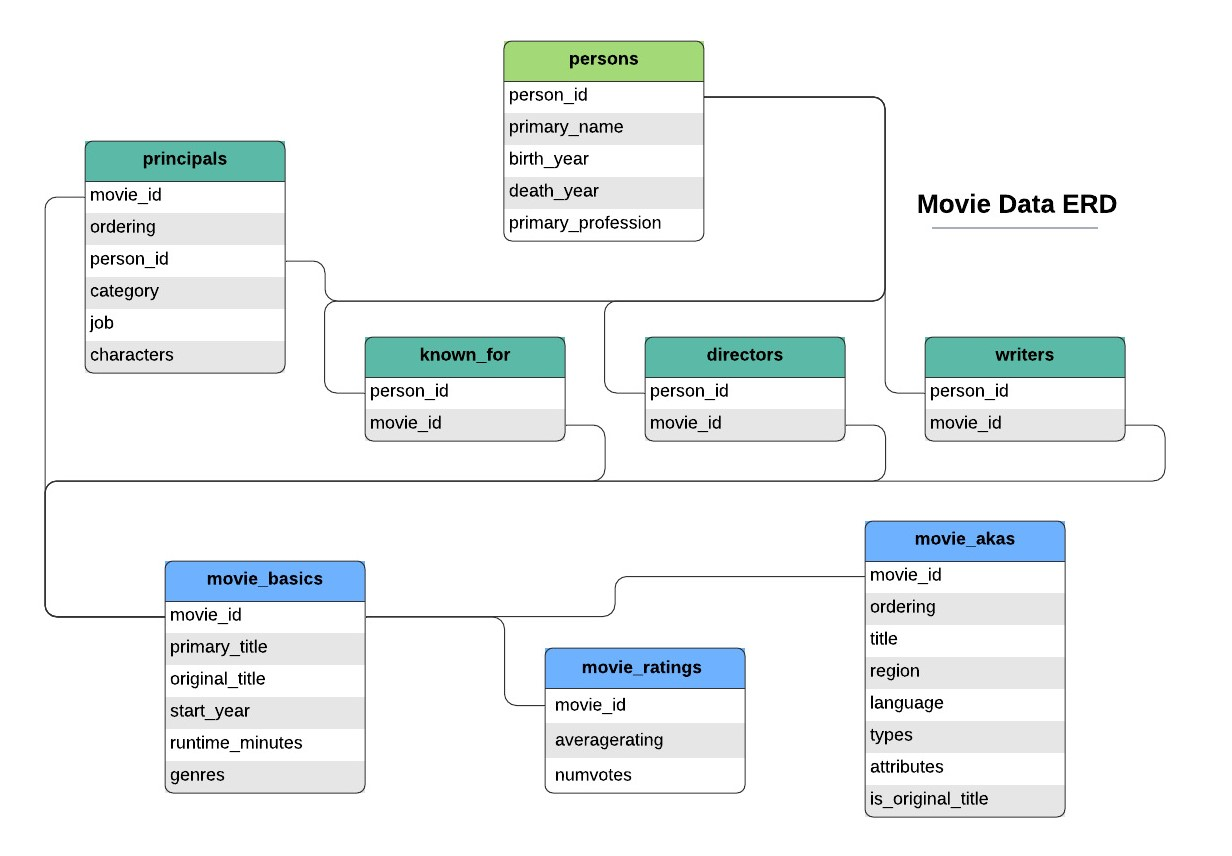

For information about revenue, we will use the **bom.movie_gross.csv** file:

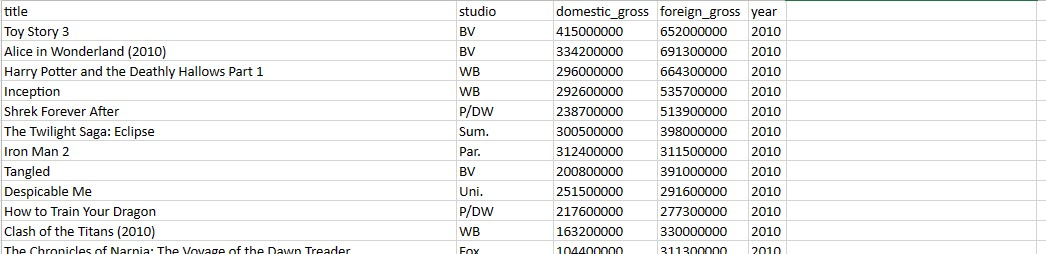

## Importing the data

In [1]:
# import relevant librarires
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick # to format the axis
import seaborn as sns
sns.set_style('darkgrid')
import sqlite3
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
#connecting to the db
conn = sqlite3.connect('im.db')

#getting a list of all the tables
tables = pd.read_sql("""SELECT name FROM sqlite_master WHERE type = 'table';""", conn)
tables

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


## EDA

Let's explore each table in the db and see what they look like:

### movie_basics 

Since the **movie_basics** table is the main table, let's start here:

In [3]:
#converting the table into a dataframe
df_movie = pd.read_sql("""SELECT *
                    FROM movie_basics""",conn)
df_movie.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


Like the name suggests, the **movie_basics** lists basic info about each movie like name, release year, genre etc. Also, since the **movie_id** serves as the foreign key in other tables, we will have to join the **movie_basics** table to other tables extract the full information.

In [4]:
df_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


Let's check the time period of the data

In [5]:
#grouping the dat by year and using count as the aggregate function
year=df_movie.groupby(df_movie['start_year']).count()
year.head()

,movie_id,primary_title,original_title,runtime_minutes,genres
start_year,,,,,
2010,11849,11849,11849,9986,11452
2011,12900,12900,12900,10707,12432
2012,13787,13787,13786,11405,13356
2013,14709,14709,14708,12308,14298
2014,15589,15589,15589,12964,15095


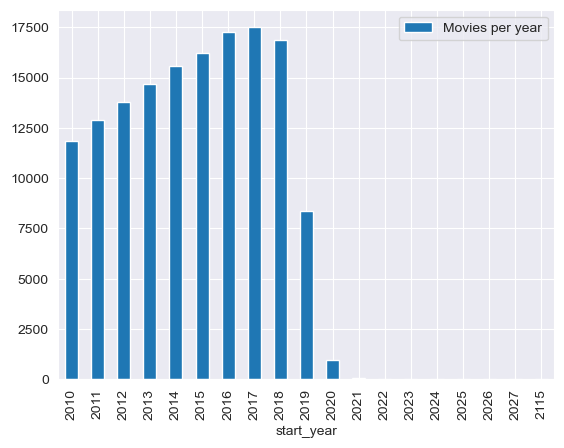

In [6]:
#plotting a histogram to view the distribution of the data
year.plot(kind='bar',y='movie_id',label='Movies per year');

We can see that dataset spans from 2010-2020 with most of the data falling between 2010-2018. We can also see some entries like 2022, 2026 etc. which clearly points to incorrect data. We should remove this from the dataset to potentially skew results.

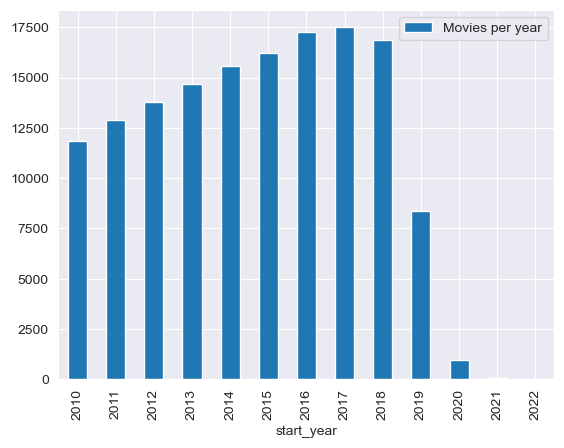

In [7]:
#removing the erroroneous data
df_movie.drop(df_movie[df_movie['start_year'] >= 2023].index,inplace=True)

#verifying that the the rows have been removed
year=df_movie.groupby(df_movie['start_year']).count()
year.plot(kind='bar',y='movie_id',label='Movies per year');

We can see that the wrong entries have been removed.

Next, let's check for missing data:

In [8]:
#checking for missing data
df_movie.isna().sum()

movie_id               0
primary_title          0
original_title        21
start_year             0
runtime_minutes    31728
genres              5405
dtype: int64

We can see that in 21 cases, the title of the movie is missing. This is not really a concern, since we're only interested in attributes of the movie like revenue, director etc. we have the information in the other tables. On the other hand, the genres column is critical information that tells us that kind of movies that are successful. Let's fill in the missing information as 'Missing' and for now. For the runtime_minutes, we can fill in the missing information using the medial value.

In [9]:
#filling the missing data for runtime_minutes using the median value
df_movie['runtime_minutes'].fillna(df_movie['runtime_minutes'].median(),inplace=True)

#filling the missing data for genres with 'MISSING'
df_movie['genres'].fillna('missing',inplace=True)

#filling the missing data for original_title with 'MISSING'
df_movie['original_title'].fillna('missing',inplace=True)

In [10]:
#verifying that we have no more missing data
df_movie.isna().sum()

movie_id           0
primary_title      0
original_title     0
start_year         0
runtime_minutes    0
genres             0
dtype: int64

### directors

In [11]:
df_directors = pd.read_sql("""SELECT *
                              FROM directors""",conn)
df_directors.head()

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540
3,tt0835418,nm0151540
4,tt0878654,nm0089502


The **directors** table only lists the the id of the director and the movie which will be useful to plot total revenue by each director.

In [12]:
df_directors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291174 entries, 0 to 291173
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   movie_id   291174 non-null  object
 1   person_id  291174 non-null  object
dtypes: object(2)
memory usage: 4.4+ MB


Although there is no missing data, we can see that there is more information about directors i.e. 291,174 rows compared to the **movie_basics** table which has only 146,133 rows. We will have to ascertain whether this might be useful or not for our analysis.

### known_for

In [13]:
df_known = pd.read_sql("""SELECT *
                          FROM known_for""", conn)
df_known.head()

,person_id,movie_id
0,nm0061671,tt0837562
1,nm0061671,tt2398241
2,nm0061671,tt0844471
3,nm0061671,tt0118553
4,nm0061865,tt0896534


The **known_for** table could be talking about the lead actor or actress in each movie.

In [14]:
df_known.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1638260 entries, 0 to 1638259
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   person_id  1638260 non-null  object
 1   movie_id   1638260 non-null  object
dtypes: object(2)
memory usage: 25.0+ MB


Similar to the **directors** table, there is far more information provided here i.e 1,638,260 rows(!) compared to the **movie_basics** & the **directors** table. Moving on to the next table...

### movie_akas

In [15]:
df_akas = pd.read_sql("""SELECT *
                         FROM movie_akas""",conn)
df_akas.head()

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.0
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.0


The **movie_akas** table lists information like the language of the movie and the country it was released which could be useful when we try to gather revenue details by region and language. 

In [16]:
df_akas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331703 entries, 0 to 331702
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   movie_id           331703 non-null  object 
 1   ordering           331703 non-null  int64  
 2   title              331703 non-null  object 
 3   region             278410 non-null  object 
 4   language           41715 non-null   object 
 5   types              168447 non-null  object 
 6   attributes         14925 non-null   object 
 7   is_original_title  331678 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 20.2+ MB


The table seems quite chaotic with lots of missing data in more than a few columns. It also now looks like the mismatch with  **movie_basics** table runs thru the dataset. It is quite apparent that this is not good quality data and we will need to work with better data to provide better recommendations.

In [17]:
#checking for missing data
df_akas.isna().sum()

movie_id                  0
ordering                  0
title                     0
region                53293
language             289988
types                163256
attributes           316778
is_original_title        25
dtype: int64

Let's examine the columns with missing data more closely:

In [18]:
df_akas.loc[:,['region','language','attributes','types']]

,region,language,attributes,types
0,BG,bg,None,None
1,JP,None,None,imdbDisplay
2,BR,None,None,imdbDisplay
3,BR,None,short title,None
4,FR,None,None,imdbDisplay
...,...,...,...,...
331698,None,None,None,original
331699,XWW,en,None,imdbDisplay
331700,None,None,None,original
331701,ES,None,None,None


Key columns like **region and language** have quite a lot of missing especially in the case of **language**. As we've done before, let's call the missing values as  'missing' and work thru the other tables in the db.

In [19]:
#replacing the missing data 
df_akas.fillna('missing',inplace=True)

#verifying 
df_akas.isna().sum()

movie_id             0
ordering             0
title                0
region               0
language             0
types                0
attributes           0
is_original_title    0
dtype: int64

### movie_ratings

In [20]:
df_ratings = pd.read_sql("""SELECT *
                          FROM movie_ratings""", conn)
df_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


The **movie_ratings** table is straight-forward and provides ratings of each movie.

In [21]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


Looks like the **movie_ratings** table is also the smallest table in the db and hence might not be very useful at all. But, let's have open mind before we disregard it.

### Revenue

As explained earlier, since we're looking at revenue as the main metric of success, we also need to look at the **bom_movie_gross.csv** file and see how we can tie that it in to the rest of the db for our analysis.

In [22]:
#creating a df of the revenue file
df_revenue = pd.DataFrame(pd.read_csv('bom.movie_gross.csv'))
df_revenue.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [23]:
df_revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


We have a major problem here. Earlier, we defined success based on gross revenue and since it is now apparent that we have very little of that data available, this make the dataset insufficient for our analysis. Given this fact and combined with the other inadequacies of this dataset, means that we have to look elsewhere for better quality data.

## Sourcing new data

Fortunately, [Opus Data](https://www.opusdata.com/) was able to provide the data. While some of the data requires us to payment, they offered an 'extract' of their data that can be used solely for academic purposes. The file is titled *'MovieData.csv'* which is what we'll use moving forward.

In [24]:
#importing the new csv file
df = pd.read_csv('MovieData.csv')
df.head()

,movie_name,production_year,movie_odid,production_budget,domestic_box_office,international_box_office,rating,creative_type,source,production_method,genre,sequel,running_time
0,Madea's Family Reunion,2006,8220100,10000000,63257940,62581,PG-13,Contemporary Fiction,Based on Play,Live Action,Comedy,1.0,NaN
1,Krrish,2006,58540100,10000000,1430721,31000000,Not Rated,Science Fiction,Original Screenplay,Live Action,Action,1.0,NaN
2,End of the Spear,2006,34620100,10000000,11748661,175380,PG-13,Historical Fiction,Original Screenplay,Live Action,Drama,0.0,NaN
3,A Prairie Home Companion,2006,24910100,10000000,20342852,6373339,PG-13,Contemporary Fiction,Original Screenplay,Live Action,Comedy,0.0,105.0
4,Saw III,2006,5840100,10000000,80238724,83638091,R,Contemporary Fiction,Original Screenplay,Live Action,Horror,1.0,NaN


In [25]:
#getting info 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936 entries, 0 to 1935
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   movie_name                1936 non-null   object 
 1   production_year           1936 non-null   int64  
 2   movie_odid                1936 non-null   int64  
 3   production_budget         1936 non-null   int64  
 4   domestic_box_office       1936 non-null   int64  
 5   international_box_office  1936 non-null   int64  
 6   rating                    1913 non-null   object 
 7   creative_type             1923 non-null   object 
 8   source                    1915 non-null   object 
 9   production_method         1925 non-null   object 
 10  genre                     1926 non-null   object 
 11  sequel                    1934 non-null   float64
 12  running_time              1822 non-null   float64
dtypes: float64(2), int64(5), object(6)
memory usage: 196.8+ KB


Looking at the columns above, we can see we have information about movie budgets and box office revenue for domestic and international markets that are crucial to for our analysis.

## EDA

### missing data

Checking for missing data:

In [26]:
#checking for missing data
df.isna().sum()

movie_name                    0
production_year               0
movie_odid                    0
production_budget             0
domestic_box_office           0
international_box_office      0
rating                       23
creative_type                13
source                       21
production_method            11
genre                        10
sequel                        2
running_time                114
dtype: int64

We can see that except for the *running_time*, the rest of the columns have < 1% of the data missing which means we can either choose to remove the rows and fill them as 'missing' for the categorical data. For *running_time and sequel*, we can impute the median value. The median is more reliable as it is less affected by outliers.

In [27]:
#getting the list of categorical columns
df_cat = df.select_dtypes(include=object)
cats = df_cat.columns

#replcaing the missing values as 'Missing'
for col in cats:
    df[col].fillna('Missing',inplace=True)

    
#imputing median value for running_time
df['running_time'].fillna(df['running_time'].median(),inplace=True)
df['sequel'].fillna(df['sequel'].median(),inplace=True)

#checking for missing data
df.isna().sum()

movie_name                  0
production_year             0
movie_odid                  0
production_budget           0
domestic_box_office         0
international_box_office    0
rating                      0
creative_type               0
source                      0
production_method           0
genre                       0
sequel                      0
running_time                0
dtype: int64

We do not have any more missing data.

Let's check some attribute of the data. We can define a function to simplify things:

In [28]:
def column_name(column):
    col_df = df.groupby(df[column]).count()
    col_df.plot(kind = 'bar',y = 'movie_name',label = f'Movies by {column}')

### time span

Time span of the data:

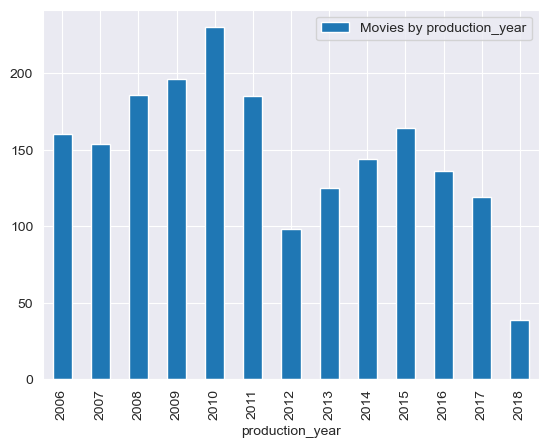

In [29]:
column_name('production_year')

We can see that the data ranges from 2006-2018

### genres

Let's check for the different genres and their representation:

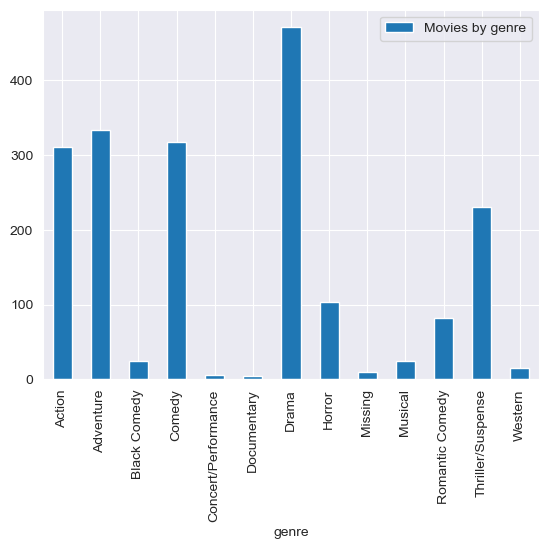

In [30]:
column_name('genre')

We can see that *Drama* ranks the highest amongst movies produced, while *Action,Adventure & Comedy*, though lesser than *Drama* are all almost equally represented.

### budgets

What about budget? What are typical budgets for movies in our dataset?

Let's get some summary statistics about the budget

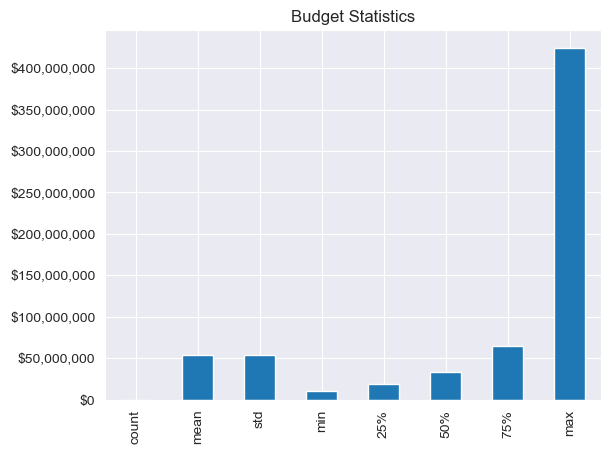

In [31]:
fig,ax=plt.subplots()
# to get the dollar sign
ax.yaxis.set_major_formatter('${x:1.2f}')
#to get the comma
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
#plotting the stats
stats = df['production_budget'].describe()
stats.plot(kind='bar',title='Budget Statistics');

We can see that there were movies produced with some eye-watering numbers i.e excess of *400 million USD*. Median budget is approx. *40 million USD* while the least budget is approx. less than *5 million USD*. 

What if we looked at budgets by year? Did budgets of movies increase, decrease or stay the same through the different years?

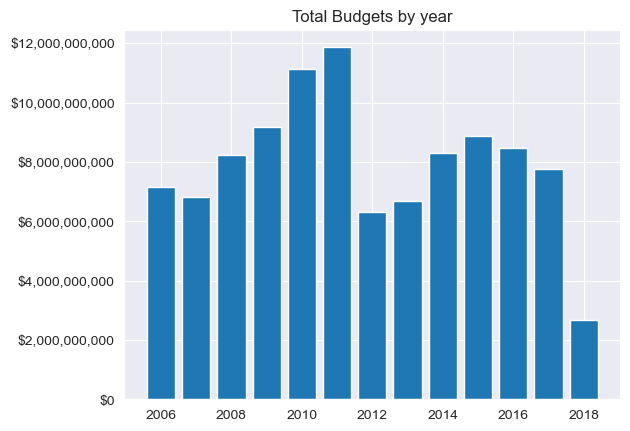

In [32]:
# #grouping movies by year and budgets
budget_years = df.groupby(by=['production_year']).sum()
#plotting
fig,ax=plt.subplots()
# to get the dollar sign
ax.yaxis.set_major_formatter('${x:1.2f}')
#to get the comma
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
# getting the sum of the budgets
# budget_years.plot(kind='bar',y='production_budget');
ax.bar(x=budget_years.index,height=budget_years['production_budget']);
ax.set_title('Total Budgets by year');


We can see that between 2006-2011, there is an upward trend, before a drastic fall off in 2012 and then total budgets never recovering to their earlier highs.

### creative_type

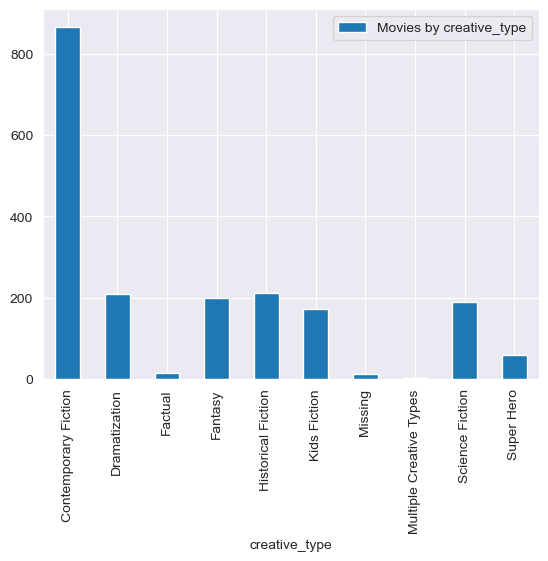

In [33]:
column_name('creative_type')

*Fiction* movies are the highest types of movies that were produced

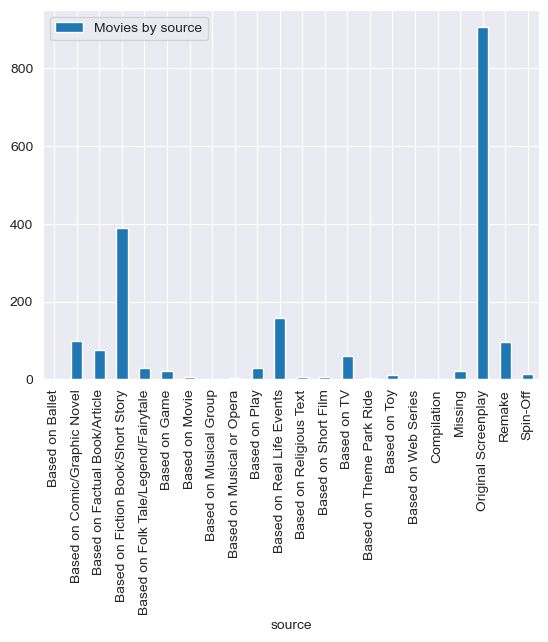

In [34]:
column_name('source')

Most movies that were produced were based on *oiginal_screenplays*. Nearly a third of the movies produced were based on books.

### Revenue

There are many different ways we can look at revenue:
1. Total revenue i.e. both international and domestic or each market individually
2. Revenue by genres, rating, budget etc.

For the sake of simplicity, let's look at *total revenue*:

In [35]:
# calculate total_revenue
df['total_revenue'] = df['domestic_box_office'] + df['international_box_office']

We can build a function to look at total revenue using different attributes i.e ratings, genre etc.

In [67]:
def total_revenue(column_name):
    col_df = df.groupby(df[column_name]).sum()
    
    #sort in descending order for easy viz
    col_df.sort_values(by=['total_revenue'],inplace=True,ascending=False)
    
    #plotting
    fig,ax = plt.subplots(figsize=(15,10))
    # to get the dollar sign
    ax.yaxis.set_major_formatter('${x:1.2f}')
    #to get the comma
    fmt = '${x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax.yaxis.set_major_formatter(tick)
    #plotting data
    ax.bar(x=col_df.index,height=col_df['total_revenue']);
    ax.tick_params(axis='x',labelrotation=90,labelsize=15);
    ax.tick_params(axis='y',labelsize=15);
    ax.set_title(f'Total Revenues by {column_name}',{'fontsize':20});

#### total revenue by genre

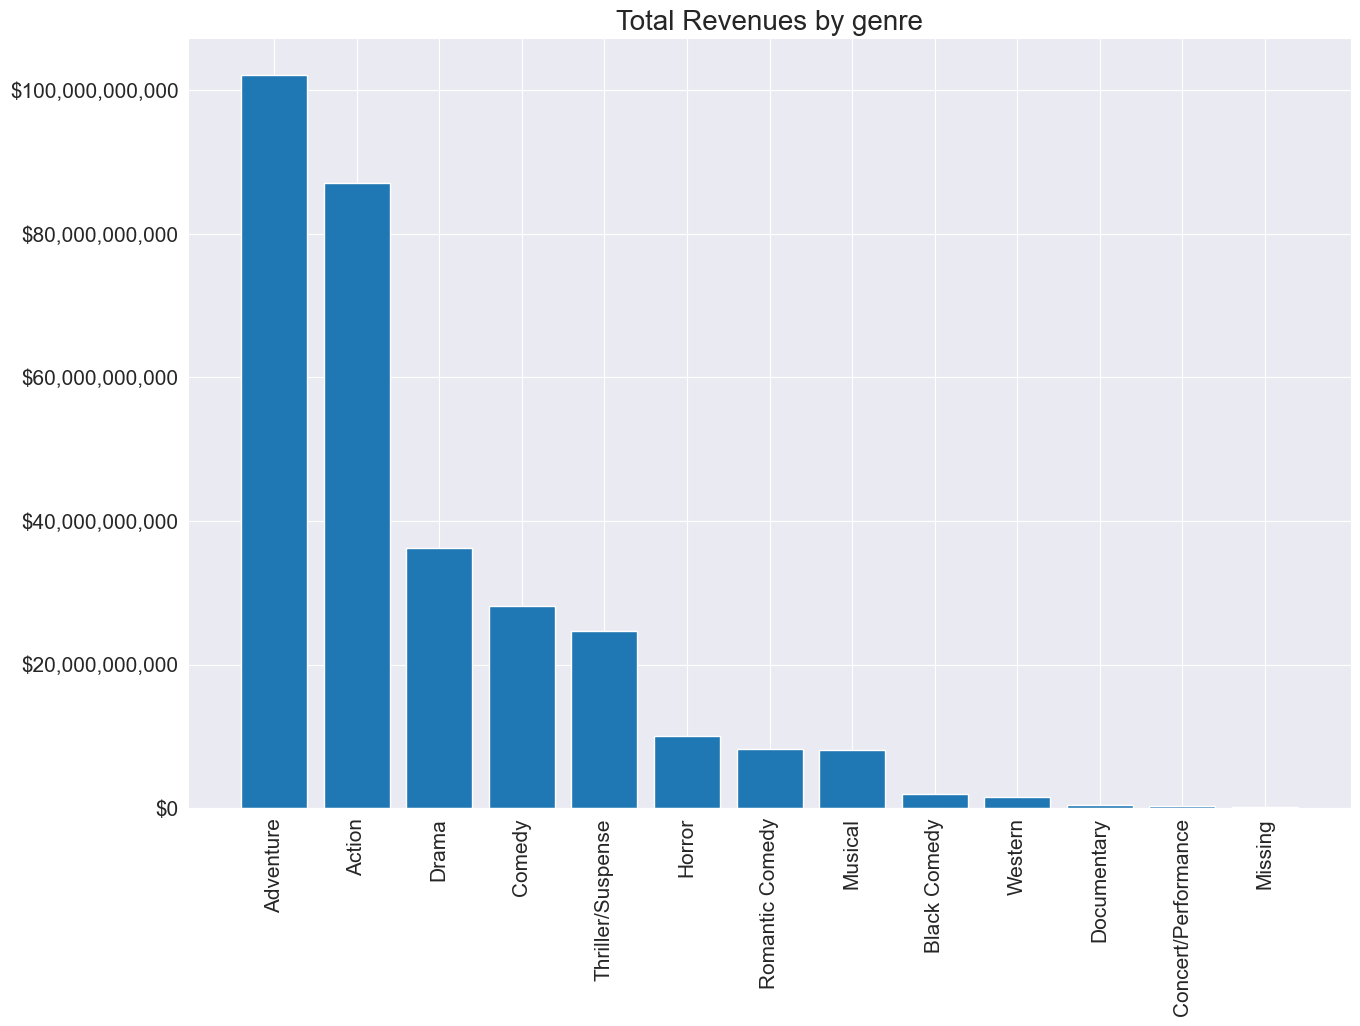

In [68]:
total_revenue('genre')

*Adventure* movies have grossed the highest revenue amongst all the genres produced. It is interesting to note that though *Drama* movies ranked the highest in number of movies made, it only third in terms of revenue; less than half of *Adventure* movies.

#### total revenue by ratings

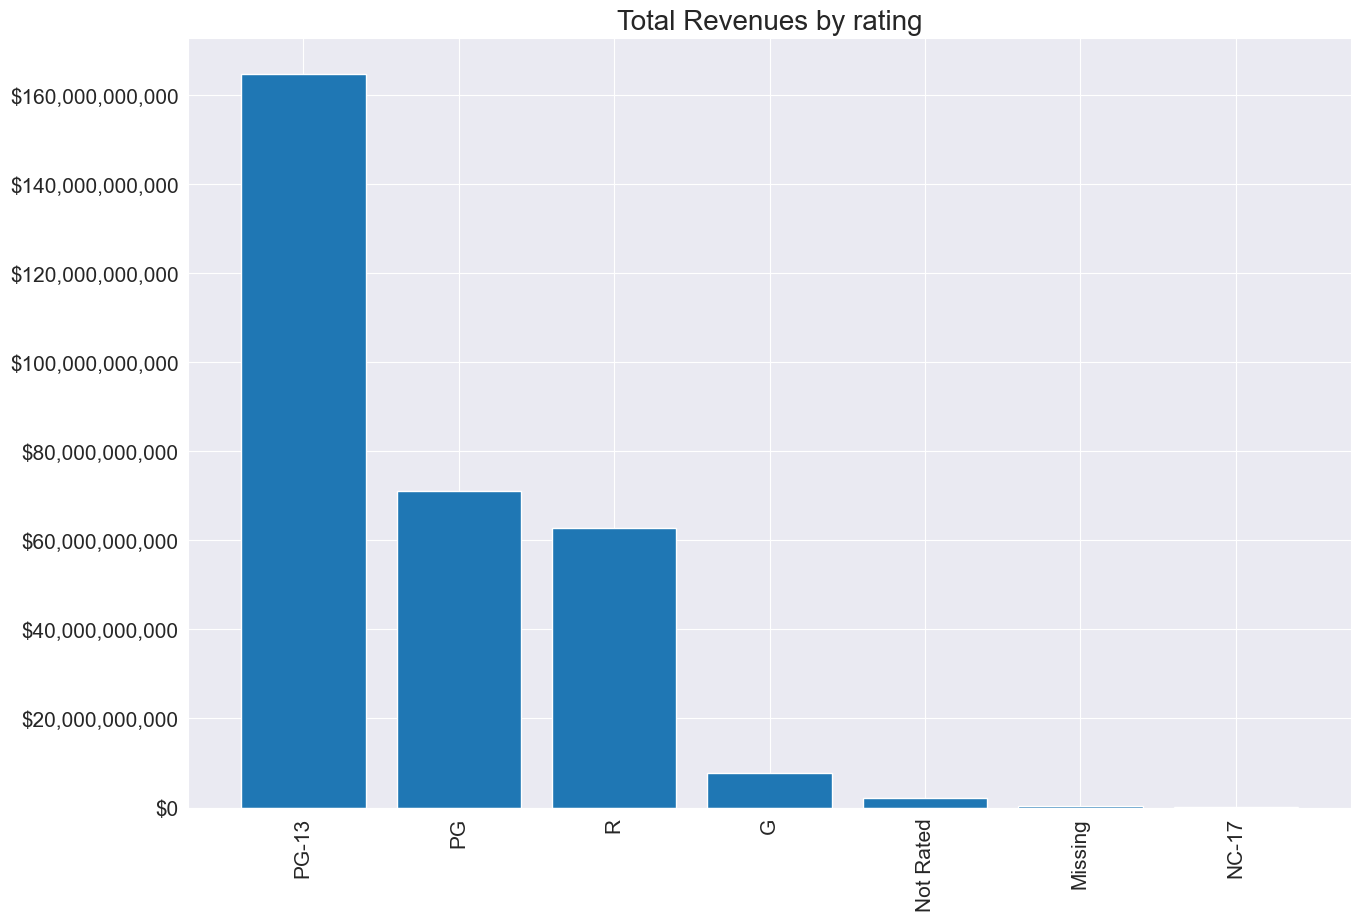

In [70]:
total_revenue('rating')

In [71]:
df.head()

,movie_name,production_year,movie_odid,production_budget,domestic_box_office,international_box_office,rating,creative_type,source,production_method,genre,sequel,running_time,total_revenue
0,Madea's Family Reunion,2006,8220100,10000000,63257940,62581,PG-13,Contemporary Fiction,Based on Play,Live Action,Comedy,1.0,108.0,63320521
1,Krrish,2006,58540100,10000000,1430721,31000000,Not Rated,Science Fiction,Original Screenplay,Live Action,Action,1.0,108.0,32430721
2,End of the Spear,2006,34620100,10000000,11748661,175380,PG-13,Historical Fiction,Original Screenplay,Live Action,Drama,0.0,108.0,11924041
3,A Prairie Home Companion,2006,24910100,10000000,20342852,6373339,PG-13,Contemporary Fiction,Original Screenplay,Live Action,Comedy,0.0,105.0,26716191
4,Saw III,2006,5840100,10000000,80238724,83638091,R,Contemporary Fiction,Original Screenplay,Live Action,Horror,1.0,108.0,163876815


In [39]:
# #group revenue by genres
# genres = df.groupby(df['genre']).sum()

# #sort in descending order for easy viz
# genres.sort_values(by=['total_revenue'],inplace=True,ascending=False)

# #plotting
# fig,ax = plt.subplots(figsize=(15,10))
# # to get the dollar sign
# ax.yaxis.set_major_formatter('${x:1.2f}')
# #to get the comma
# fmt = '${x:,.0f}'
# tick = mtick.StrMethodFormatter(fmt)
# ax.yaxis.set_major_formatter(tick)
# #plotting data
# ax.bar(x=genres.index,height=genres['total_revenue']);
# ax.tick_params(axis='x',labelrotation=90,labelsize=15)
# ax.tick_params(axis='y',labelsize=15)
# ax.set_title('Total Revenues by Genre',{'fontsize':15});